### **Read data**

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

data_root = './dataset'
data_path = os.path.join(data_root, 'churn_data_clean.csv')

df = pd.read_csv(data_path)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,29.85,29.85,0,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,1,0,1,0,0,0,0,56.95,1889.50,0,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,0,1,1,0,0,0,0,1,53.85,108.15,1,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,1,0,1,1,0,0,0,42.30,1840.75,0,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,0,0,0,0,0,0,0,1,70.70,151.65,1,0,1,0,1,0,0,0,0,1,0


In [2]:
df.shape

(10348, 27)

### **Split Data**
Split data into training, validation, testing set with ratio 7:1:2

In [3]:
X = df.loc[:, df.columns != 'Churn'] # Features
y = df.loc[:, df.columns == 'Churn'] # Target
print(X.shape)
print(y.shape)

(10348, 26)
(10348, 1)


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

print('Training set: ', y_train.shape)
print('Validation set: ', y_val.shape)
print('Testing set: ', y_test.shape)

Training set:  (7243, 1)
Validation set:  (1035, 1)
Testing set:  (2070, 1)


In [5]:
X_train.head(10)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
1939,1,0,0,1,1,1,0,0,0,0,0,0,0,1,21.050000,21.050000,0,0,1,1,0,0,0,0,0,1
2497,0,0,1,0,4,1,0,0,0,0,0,0,0,0,19.600000,93.450000,0,0,1,1,0,0,0,0,0,1
5222,0,0,0,0,8,1,1,1,1,1,0,0,0,1,65.500000,573.150000,1,0,0,1,0,0,1,0,0,0
7482,1,0,0,0,3,1,0,0,0,0,0,0,0,1,70.067047,233.635071,0,1,0,1,0,0,0,0,1,0
229,0,0,1,1,47,1,1,1,1,0,1,1,1,1,85.300000,4107.250000,1,0,0,0,0,1,0,1,0,0
4876,1,0,0,0,10,1,0,1,1,1,0,1,1,1,104.400000,1081.450000,0,1,0,1,0,0,0,0,1,0
2914,1,0,0,0,32,1,0,0,0,0,0,1,1,1,64.850000,2010.950000,1,0,0,0,1,0,1,0,0,0
68,0,0,1,1,50,1,0,0,0,0,0,0,0,0,20.150000,930.900000,0,0,1,0,0,1,1,0,0,0
7832,1,0,1,0,66,1,1,0,1,1,1,1,1,1,106.060504,7139.740286,0,1,0,0,1,0,0,0,1,0
7494,0,1,0,0,52,1,1,0,1,0,0,1,0,1,83.370580,4349.291005,0,1,0,1,0,0,0,0,1,0


In [6]:
X_val.head(10)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
5853,1,0,1,0,62,1,1,1,1,0,0,0,1,0,96.100000,6001.450000,0,1,0,0,1,0,0,0,1,0
4882,0,0,0,0,66,0,0,1,1,1,1,1,1,1,62.500000,4136.400000,1,0,0,0,0,1,1,0,0,0
2414,0,0,1,0,25,1,0,0,0,0,0,0,0,1,20.200000,507.900000,0,0,1,0,1,0,1,0,0,0
5642,0,0,0,0,20,1,0,0,0,0,0,0,0,0,19.500000,403.150000,0,0,1,0,1,0,0,0,0,1
8623,1,0,0,0,2,1,0,0,0,0,0,0,0,1,44.767381,94.317657,1,0,0,1,0,0,0,0,1,0
1128,1,0,0,0,27,1,0,0,0,0,0,0,0,1,19.400000,529.800000,0,0,1,1,0,0,0,0,1,0
6990,1,0,1,0,36,1,0,1,0,0,0,1,1,1,93.600000,3366.050000,0,1,0,1,0,0,0,0,1,0
4849,1,0,0,0,41,0,0,0,0,1,0,1,1,1,51.350000,2075.100000,1,0,0,0,1,0,0,0,1,0
5744,1,1,1,0,40,1,0,0,0,0,0,0,1,0,55.800000,2283.300000,1,0,0,0,1,0,0,0,1,0
9067,1,0,0,0,55,1,0,1,1,0,0,0,0,1,40.541898,2106.960062,1,0,0,1,0,0,0,0,1,0


In [7]:
X_test.head(10)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
9428,1,0,0,0,47,1,1,0,0,1,0,1,1,1,93.853385,4506.133022,0,1,0,1,0,0,0,0,1,0
4593,0,0,0,0,11,1,0,0,0,0,0,0,0,0,20.300000,246.300000,0,0,1,1,0,0,1,0,0,0
5379,0,0,1,0,56,1,1,1,0,0,0,1,1,1,98.000000,5270.600000,0,1,0,0,1,0,0,0,1,0
8918,1,0,0,0,8,1,0,0,0,0,0,0,0,1,74.938341,631.572940,0,1,0,1,0,0,0,0,1,0
6448,1,0,0,0,58,1,1,0,0,1,1,1,1,1,104.650000,6219.600000,0,1,0,0,1,0,0,0,1,0
6060,0,1,0,0,8,1,0,0,1,0,0,1,0,1,87.100000,713.600000,0,1,0,1,0,0,0,0,1,0
850,0,0,1,1,72,1,1,1,1,1,1,1,1,1,115.800000,8476.500000,0,1,0,0,0,1,1,0,0,0
713,0,0,0,1,14,1,1,1,0,0,1,0,0,1,86.000000,1164.050000,0,1,0,1,0,0,0,0,0,1
8661,1,0,0,0,3,0,0,0,0,0,0,0,0,0,27.602254,74.301170,1,0,0,1,0,0,0,0,1,0
4438,1,0,1,1,51,1,1,0,0,0,0,0,0,1,24.950000,1222.250000,0,0,1,0,0,1,0,0,0,1


### **Normalization**

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_val_normalized = scaler.transform(X_val)
X_test_normalized = scaler.transform(X_test)

### **Bagging SVM**

In [9]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

svm_classifier = SVC(random_state=42)

bagging_svm = BaggingClassifier(base_estimator=svm_classifier, random_state=42)

# Measure the training time of the model
t0 = time.time()

bagging_svm.fit(X_train, y_train.values.ravel())

print(f'Training time: {(time.time()-t0):.2f} s')

c:\Users\xiaoc\anaconda3\envs\keras\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training time: 20.87 s


Accuracy: 0.6406
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.71      0.67       524
           1       0.66      0.57      0.61       511

    accuracy                           0.64      1035
   macro avg       0.64      0.64      0.64      1035
weighted avg       0.64      0.64      0.64      1035



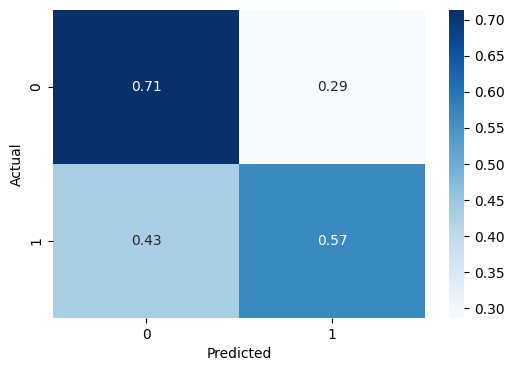

In [10]:
y_val_bagging_pred = bagging_svm.predict(X_val)
accuracy = accuracy_score(y_val, y_val_bagging_pred)

print(f'Accuracy: {accuracy:.4f}')

print('Classification Report:')
print(classification_report(y_val, y_val_bagging_pred))
bagging_confmat = confusion_matrix(y_val, y_val_bagging_pred, normalize='true')

plt.figure(figsize=(6,4))
sns.heatmap(bagging_confmat,annot=True,cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [11]:
svm_classifier.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

#### *Hyper-parameters Tuning for SVM*

In [12]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C' : [0.1, 1, 10, 100, 1000], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1], 'kernel': ['rbf','sigmoid']}
svm_grid = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, scoring='accuracy', verbose=3)
svm_grid.fit(X_train,y_train.values.ravel())

# print best parameter after tuning 
print(svm_grid.best_params_) 

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.693 total time=   3.1s
[CV 2/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.715 total time=   3.2s
[CV 3/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.703 total time=   3.3s
[CV 4/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.711 total time=   4.7s
[CV 5/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.725 total time=   3.6s
[CV 1/5] END C=0.1, gamma=0.0001, kernel=sigmoid;, score=0.586 total time=   1.9s
[CV 2/5] END C=0.1, gamma=0.0001, kernel=sigmoid;, score=0.594 total time=   2.0s
[CV 3/5] END C=0.1, gamma=0.0001, kernel=sigmoid;, score=0.602 total time=   2.0s
[CV 4/5] END C=0.1, gamma=0.0001, kernel=sigmoid;, score=0.605 total time=   2.8s
[CV 5/5] END C=0.1, gamma=0.0001, kernel=sigmoid;, score=0.395 total time=   3.4s
[CV 1/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.723 total time=   6.6s
[CV 2/5] END ....C=0.1, gamma=0.001, kerne

In [13]:
svm_grid.best_estimator_

SVC(C=1000, gamma=0.0001, random_state=42)

In [14]:
svm_grid.best_score_

0.8279729018679296

#### **Tuned Bagging SVM**

In [15]:
best_c = svm_grid.best_params_.get('C')
best_gamma = svm_grid.best_params_.get('gamma')

# Use Hyper-parameter tuned SVM as base estimator
svm_tune = SVC(gamma=best_gamma, C=best_c)

bagging_svm_tune = BaggingClassifier(base_estimator=svm_tune, random_state=42)

# Measure the training time of the model
t0 = time.time()

bagging_svm_tune.fit(X_train, y_train.values.ravel())

print(f'Training time: {time.time()-t0:.2f} s')

c:\Users\xiaoc\anaconda3\envs\keras\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training time: 68.79 s


Accuracy: 0.8232
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       524
           1       0.80      0.85      0.83       511

    accuracy                           0.82      1035
   macro avg       0.82      0.82      0.82      1035
weighted avg       0.82      0.82      0.82      1035



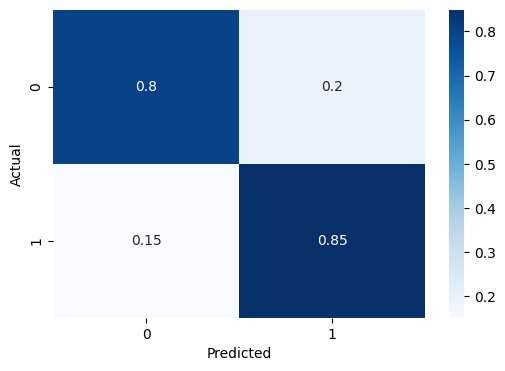

In [16]:
y_val_bagging_tune_pred = bagging_svm_tune.predict(X_val)
accuracy_tune = accuracy_score(y_val, y_val_bagging_tune_pred)

print(f'Accuracy: {accuracy_tune:.4f}')

print('Classification Report:')
print(classification_report(y_val, y_val_bagging_tune_pred))
bagging_tune_confmat = confusion_matrix(y_val, y_val_bagging_tune_pred, normalize='true')

plt.figure(figsize=(6,4))
sns.heatmap(bagging_tune_confmat,annot=True,cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### **PCA**
Choose the number of components for which the cumulative explained variance exceeds a threshold of 0.95 (95%).

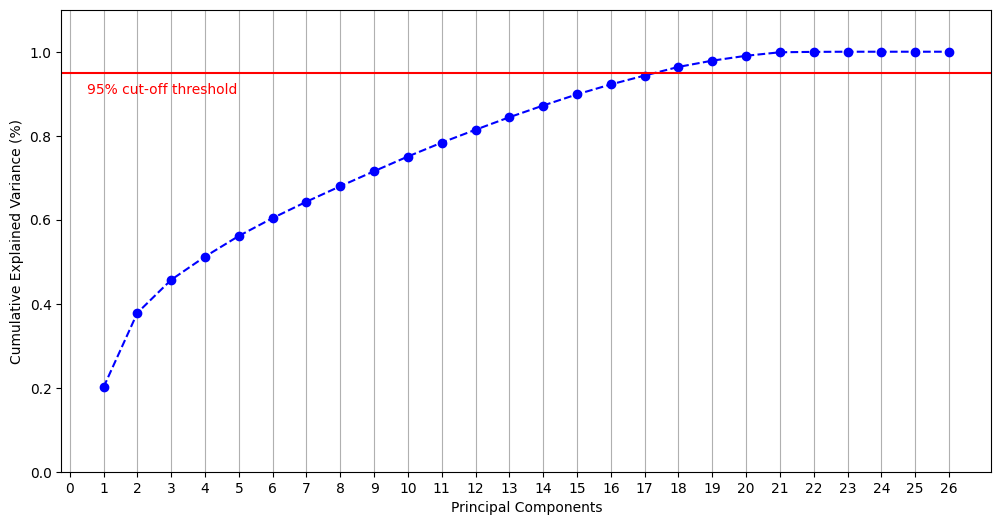

In [17]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA().fit(X_train_normalized)

plt.rcParams["figure.figsize"] = (12,6)
fig, ax = plt.subplots()
xi = np.arange(1, 27, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Principal Components')
plt.xticks(np.arange(0, 27, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative Explained Variance (%)')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.9, '95% cut-off threshold', color = 'red')

ax.grid(axis='x')
plt.show()

In [18]:
from sklearn.decomposition import PCA

pca = PCA(.95)
pca.fit(X_train_normalized)
X_train_pca = pca.transform(X_train_normalized)
X_val_pca = pca.transform(X_val_normalized)
X_test_pca = pca.transform(X_test_normalized)

### **Bagging SVM with PCA**

In [19]:
bagging_svm_pca = BaggingClassifier(base_estimator=svm_classifier, random_state=42)

# Measure the training time of the model
t0 = time.time()

bagging_svm_pca.fit(X_train_pca, y_train.values.ravel())

print(f'Training time: {time.time()-t0:.2f} s')

c:\Users\xiaoc\anaconda3\envs\keras\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training time: 10.27 s


Accuracy: 0.8019
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.78      0.80       524
           1       0.79      0.82      0.80       511

    accuracy                           0.80      1035
   macro avg       0.80      0.80      0.80      1035
weighted avg       0.80      0.80      0.80      1035



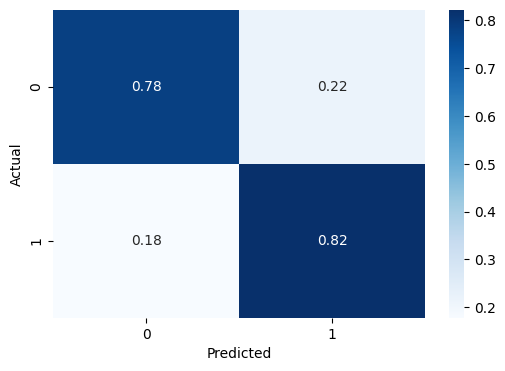

In [20]:
y_val_bagging_pca_pred = bagging_svm_pca.predict(X_val_pca)
accuracy_pca = accuracy_score(y_val, y_val_bagging_pca_pred)

print(f'Accuracy: {accuracy_pca:.4f}')

print('Classification Report:')
print(classification_report(y_val, y_val_bagging_pca_pred))
bagging_pca_confmat = confusion_matrix(y_val, y_val_bagging_pca_pred, normalize='true')

plt.figure(figsize=(6,4))
sns.heatmap(bagging_pca_confmat,annot=True,cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### *Hyper-parameters Tuning SVM with PCA*

In [21]:
param_grid = {'C' : [0.1, 1, 10, 100, 1000], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1], 'kernel': ['rbf','sigmoid']}
svm_pca_grid = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, scoring='accuracy', verbose=3)
svm_pca_grid.fit(X_train_pca,y_train.values.ravel())

# print best parameter after tuning 
print(svm_pca_grid.best_params_) 

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.501 total time=   4.0s
[CV 2/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.501 total time=   4.0s
[CV 3/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.501 total time=   4.0s
[CV 4/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.501 total time=   4.2s
[CV 5/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.501 total time=   3.9s
[CV 1/5] END C=0.1, gamma=0.0001, kernel=sigmoid;, score=0.501 total time=   3.3s
[CV 2/5] END C=0.1, gamma=0.0001, kernel=sigmoid;, score=0.501 total time=   3.4s
[CV 3/5] END C=0.1, gamma=0.0001, kernel=sigmoid;, score=0.501 total time=   3.5s
[CV 4/5] END C=0.1, gamma=0.0001, kernel=sigmoid;, score=0.501 total time=   3.5s
[CV 5/5] END C=0.1, gamma=0.0001, kernel=sigmoid;, score=0.501 total time=   3.0s
[CV 1/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.775 total time=   4.0s
[CV 2/5] END ....C=0.1, gamma=0.001, kerne

In [22]:
svm_pca_grid.best_estimator_

SVC(C=1000, gamma=0.01, random_state=42)

In [23]:
svm_pca_grid.best_score_

0.8130590157433779

#### **Tuned Bagging SVM with PCA**

In [24]:
best_c = svm_pca_grid.best_params_.get('C')
best_gamma = svm_pca_grid.best_params_.get('gamma')

svm_pca_tune = SVC(gamma=best_gamma, C=best_c)

bagging_svm_pca_tune = BaggingClassifier(base_estimator=svm_pca_tune, random_state=42)

# Measure the training time of the model
t0 = time.time()

bagging_svm_pca_tune.fit(X_train_pca, y_train.values.ravel())

print(f'Training time: {time.time()-t0:.2f} s')

c:\Users\xiaoc\anaconda3\envs\keras\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training time: 33.09 s


Accuracy: 0.8077
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.79      0.81       524
           1       0.79      0.82      0.81       511

    accuracy                           0.81      1035
   macro avg       0.81      0.81      0.81      1035
weighted avg       0.81      0.81      0.81      1035



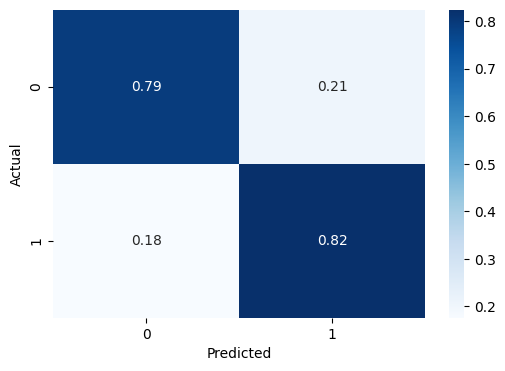

In [25]:
y_val_bagging_tune_pca_pred = bagging_svm_pca_tune.predict(X_val_pca)
accuracy_tune_pca = accuracy_score(y_val, y_val_bagging_tune_pca_pred)

print(f'Accuracy: {accuracy_tune_pca:.4f}')

print('Classification Report:')
print(classification_report(y_val, y_val_bagging_tune_pca_pred))
bagging_tune_pca_confmat = confusion_matrix(y_val, y_val_bagging_tune_pca_pred, normalize='true')

plt.figure(figsize=(6,4))
sns.heatmap(bagging_tune_pca_confmat,annot=True,cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### **Export Model**

In [26]:
import joblib

# Save model
joblib.dump(bagging_svm, './models/bagging_svm.sav')
joblib.dump(bagging_svm_tune, './models/bagging_svm_tune.sav')
joblib.dump(bagging_svm_pca, './models/bagging_svm_pca.sav')
joblib.dump(bagging_svm_pca_tune, './models/bagging_svm_pca_tune.sav')

['./models/bagging_svm_pca_tune.sav']